# Self Driving Car Engineer Nanodegree

## Project: Advanced Lane Line Finding
In this project, i am delivering a software pipeline to find lane line in the road under different conditions of lighting changes, color changes and shadows on the road in both test images and videos.

In [1]:
%%HTML
<style> code {background-color : pink !important;} </style>

## Importing Packages

In [2]:
# importing some useful packages
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob

# showing images in notebook
%matplotlib inline

## Making Line Class to help with tracking previous measured data

In [3]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # x values of the last 5 fits of the line
        self.recent_coefficients = [] 
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # number of frames
        self.storedDataNumber = 0
        # next place to append new data
        self.arraysAppendingIndex = 0
        
    def appendCoeffs(self, coeffs):
        if(self.storedDataNumber < 5):
            self.storedDataNumber = self.storedDataNumber + 1
            self.recent_coefficients.append(coeffs)
        
        if(self.storedDataNumber == 5):
            self.arraysAppendingIndex = (self.arraysAppendingIndex + 1) % 5
            self.recent_coefficients[self.arraysAppendingIndex] = coeffs

        self.best_fit = np.sum(np.array(self.recent_coefficients), axis = 0) / self.storedDataNumber
        return self.best_fit

## Read In An Image

This image of type <class 'numpy.ndarray'> , with dimenstions: (720, 1280, 3)


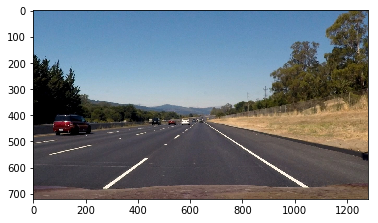

In [4]:
# Reading an image
img = mpimg.imread('test_images/straight_lines2.jpg')

# getting img dimensions and printing it
print("This image of type",type(img),", with dimenstions:",img.shape)
plt.imshow(img)

## Some Helper functions

In [5]:
# These are some helper functions to help make the code simpler ###


## STEP ONE Helper functions (Camera Calibration Helper Functions)##
### Find corners in an chessboard image
def findCorners(img, nx, ny):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return cv2.findChessboardCorners(gray, (nx, ny), None)

### Draw Corners on a chessboard image
def drawCorners(img, nx, ny, corners, ret):
    return cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

### Calibrate Camera and return matrix and undistortion matrices
def calibrateCamera(objPoints, imgPoints, imgShape):
    return cv2.calibrateCamera(objPoints, imgPoints, imgShape, None, None)

## These functions are used in the pipeline of detecting lanes in the images
def undistortImg(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
### Apply gaussian blue to eliminate noise
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


### This function returns the prespective and inverse prespective matrix for a prespective transform
def perspectiveTransform(srcPoints, dstPoints):
    M    = cv2.getPerspectiveTransform(srcPoints, dstPoints)
    Minv = cv2.getPerspectiveTransform(dstPoints, srcPoints)
    return (M, Minv)

### This function applies prespective transform to an image and returns the warped image
def warpPerspective(img, imgSize, M):
    return cv2.warpPerspective(img, M, imgSize, cv2.INTER_LINEAR)


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[3 * binary_warped.shape[0]//4:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


def search_around_poly(binary_warped, left_fit, right_fit):
    margin = 100
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = np.argwhere((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.argwhere((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    right_lane_inds = np.concatenate(right_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty


### This function sets up video line objects to be used later
def measureCurvature(y_eval, leftx, rightx):
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/(640)# meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(ym_per_pix * ploty, xm_per_pix * leftx, 2)
    right_fit_cr = np.polyfit(ym_per_pix * ploty, xm_per_pix * rightx, 2)
    y_eval = ym_per_pix * y_eval
    left_curverad = np.power((1 + np.power(2 * left_fit_cr[0] * y_eval + left_fit_cr[1],2)),3/2) / np.abs(2 * left_fit_cr[0])
    ## Implement the calculation of the right line here
    right_curverad = (np.power((1 + np.power(2 * right_fit_cr[0] * y_eval + right_fit_cr[1], 2)), 3 / 2) 
                            / np.abs(2 * right_fit_cr[0]) )  
    return left_curverad, right_curverad

## Building lanes finding pipeline:
### Camera calibration:
In This step we used chessboard images to calibrate the camera and correct for any distortion. By the end of this step, we have camera matrix and undistortion coefficients to help us later on to undistort any distortion in road images

In [6]:
### Camera Calibration ###

# Number of corners in rows and columns
nx = 9
ny = 6

# Getting calibration images
calibrationImages = glob.glob('camera_cal/calibration*.jpg')

# setting real object points and image points for corners
imgPoints = []
objPoints = []

# Making a 3-d grid for object points
objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

for imgID, imgName in enumerate(calibrationImages):
    img = cv2.imread(imgName)
    ret, corners = findCorners(img, nx, ny)

    if (ret == True):
        img = drawCorners(img, nx, ny ,corners, ret)
        imgPoints.append(corners)
        objPoints.append(objp)
        
ret, mtx, dist, rvecs, tvecs = calibrateCamera(objPoints, imgPoints, img.shape[1::-1])

#### Test Some images to check for undistortion:
Here, i capture two images and undistort them and show them side by side in a two by two figure. The first column for the original images and the second column for the undistorted ones

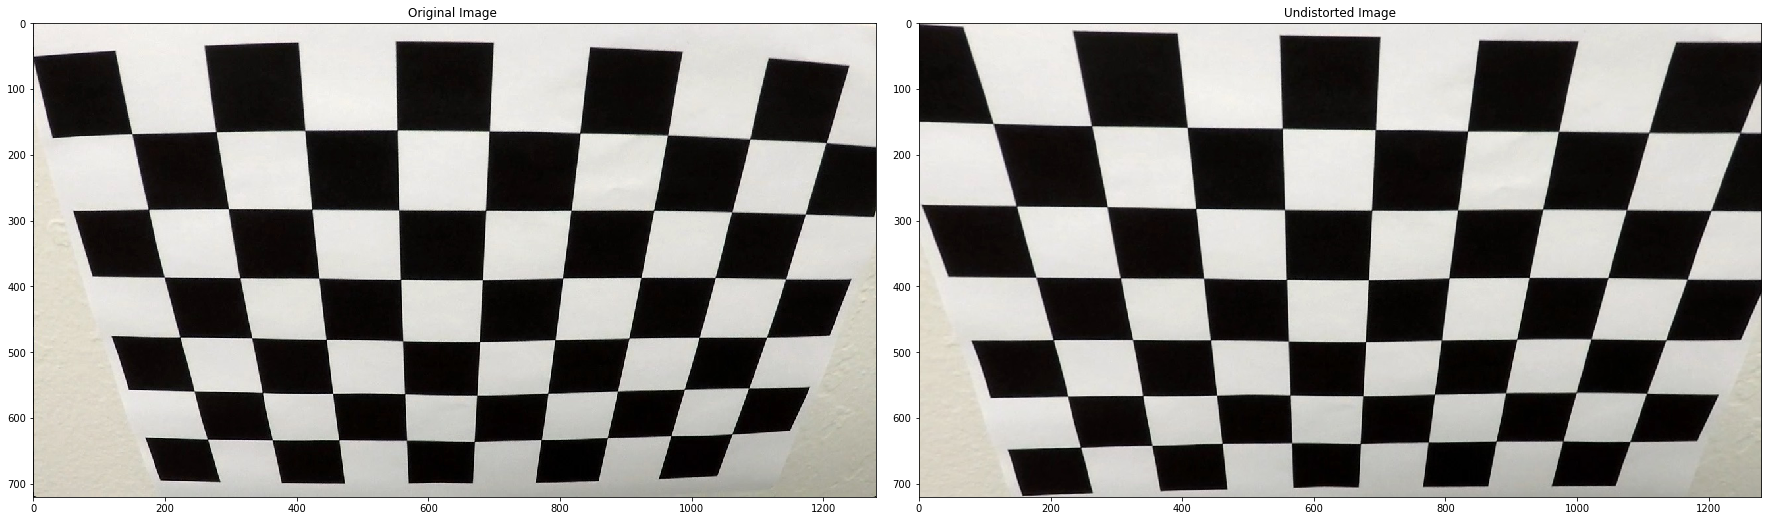

In [7]:
fig, axes = plt.subplots(1, 2, figsize = (24,9))
fig.tight_layout();
img = mpimg.imread('camera_cal/calibration2.jpg')
axes[0].imshow(img)
axes[0].set_title('Original Image ')
axes[1].imshow(undistortImg(img))
axes[1].set_title('Undistorted Image')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## LaneFinding pipeline
Here, i'm going through a series of **steps** to identify lane lines in the road. These **steps** are:
1. Undistort the image using the matrix and undistortion coefficients we got from camera calibration.
2. Get a binary image from color spaces and gradient thresholds to detect edges.
3. Apply prespective transform to get a bird's eye view on the road.
4. Detect lanes using sliding window method and then using highly targeted area search.
5. Fit a second degree polynomial to the lanes.
6. Use the inverse prespective matrix we got from **step 3** to draw the lanes on the original image.

**Note**: The pipeline neglects video frames in which the two lanes are not consistent

Below, is the software pipeline used to implement these steps.

In [8]:
# A function that draws the lane lines on an image. It has two operation modes depending on the dataType: Video and Image.
# in Video it puts in consideration previous frames data
def findLanes(img, dataType = 'Video'):
    imgSize = img.shape[1::-1]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #  we undistort the img
    undistorted = undistortImg(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sx_thresh=(20, 100)
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_thresh=(170, 255)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    
    binaryImg = np.zeros_like(sxbinary)
    binaryImg[(s_binary == 1) | (sxbinary == 1)] = 1
    
    ## Now, we apply prespective transform to get a warped image of the lanes only
    ### src points were found on 3 lanes and the width between lanes, i.e: 30 x 3.7 meters according to american standards
    srcPoints = np.float32([(.172 * img.shape[1], img.shape[0]),
                          (.463 * img.shape[1], .626 * img.shape[0]),
                          (.537 * img.shape[1], .626 * img.shape[0]),
                          (.87 * img.shape[1], img.shape[0])])
    
    # destination pts for 1280 x 720 img are (200,720) , (200,0) , (700,0) , (700,720)
    dstPoints = np.float32([(img.shape[1] // 4, img.shape[0]),
                           (img.shape[1] // 4, 0),
                           (3 * img.shape[1] // 4, 0),
                           (3 * img.shape[1] // 4, img.shape[0])])
    M , Minv = perspectiveTransform(srcPoints , dstPoints)
    # warp the image
    warped = warpPerspective(binaryImg, imgSize, M)
    ## Now, we use sliding window method with convolution to get lanes in the road
    if(dataType == 'Image'):
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
        # Fit a second order polynomial to each using `np.polyfit`
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)    
    elif(dataType == 'Video'):
        if((leftLane.storedDataNumber == 0) and (rightLane.storedDataNumber == 0)):
            leftx, lefty, rightx, righty, outImg = find_lane_pixels(warped)
        else:
            leftx, lefty, rightx, righty = search_around_poly(warped, leftLane.best_fit, rightLane.best_fit)
        
        # Fit a second order polynomial to each using `np.polyfit`
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        if(np.abs(left_fit[1] - right_fit[1]) <= .25 and np.abs(left_fit[0] - right_fit[0]) <= .25):
            left_fit = leftLane.appendCoeffs(left_fit)
            right_fit = rightLane.appendCoeffs(right_fit)
        else:
            left_fit = leftLane.appendCoeffs(leftLane.best_fit)
            right_fit = rightLane.appendCoeffs(rightLane.best_fit)
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    curvature = int(np.sum(measureCurvature(720, left_fitx, right_fitx)) / 2)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    newwarpGreenChannel = cv2.cvtColor(newwarp, cv2.COLOR_RGB2GRAY)
    newwarpGreenChannelTop = newwarpGreenChannel[719]
    newwarpGreenChannelTopNonZero = np.nonzero(newwarpGreenChannelTop)
    # Middle point between the two lanes
    laneMiddlePoint = (left_fit[0] * 720**2 + left_fit[1] * 720 + left_fit[2] + right_fit[0] * 720 **2 + right_fit[1] * 720 + 
                        right_fit[2]) / 2
    distanceFromCenter = np.round((np.abs(640 - laneMiddlePoint) / 893) * 3.7, 2)
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    mpimg.imsave('challenge/ch.jpg', result)
    #result = output
    cv2.putText(result, 'Radius of curvature = ' + str(curvature) + 'm', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 5)
    cv2.putText(result, 'Distance from center = ' + str(distanceFromCenter) + 'm', (50,170), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 5)
    return result

## Testing the pipeline on single images
Here, i am testing the pipeline on the sample images in `test_images` directory. The result of the test images can be found in `output_images` directory with the name of each test image is preceeded with `output_` before it's name

In [9]:
images = glob.glob('test_images/test*.jpg')

for imageID, imageName in enumerate(images):
    #imageName = 'examples/example_output.jpg'
    img = mpimg.imread(imageName)
    outputImg = findLanes(img, dataType='Image')
    mpimg.imsave('output_images/output_' + imageName[12:], outputImg)

### Showing the pipeline result
Here, I am demonstrating the result by showing the output images from the test images

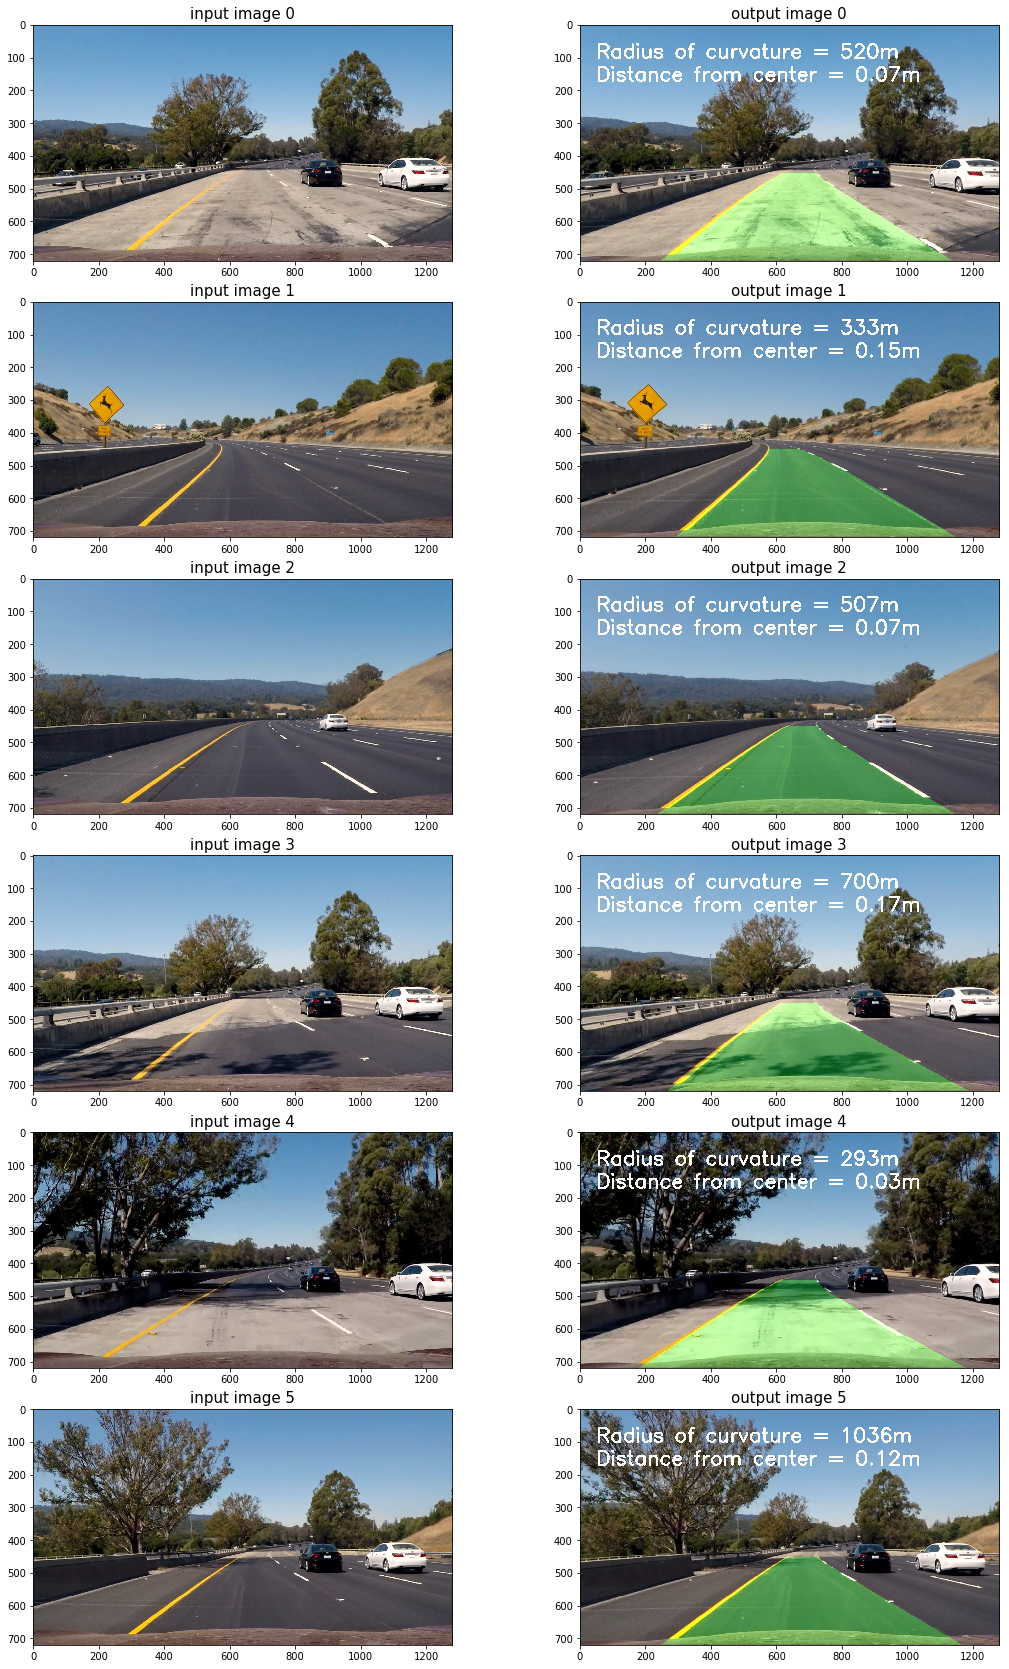

In [10]:
images = glob.glob('test_images/test*.jpg')
outputImages = glob.glob('output_images/*.jpg')
fig, axes = plt.subplots(6, 2, figsize=(48, 18))
fig.tight_layout()
fig.set_figheight(25)
fig.set_figwidth(15)
for i in range(6):
    img = mpimg.imread(images[i])
    outputImg = mpimg.imread(outputImages[i])
    axes[i, 0].imshow(img)
    axes[i, 0].set_title('input image ' + str(i), fontsize = 15)
    axes[i, 1].imshow(outputImg, cmap = 'gray')
    axes[i, 1].set_title('output image ' + str(i), fontsize = 15)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Test On Videos
Here, I'm testing the pipeline on the three videos `project_video.mp4`, `challenge_video.mp4` & `harder_challenge_video`. The output videos will be presented here in this notebook, but also, you can find them in the `output_videos` directory. Each output video's name will be preceeded by `output_` in the directory.

### Initialize video data

In [11]:
leftLane  = Line()
rightLane = Line()

## Importing Some Video Manipulating Libraries

In [12]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### First, we try the project video

In [13]:
output_project_video = 'output_videos/output_project_video.mp4'
clip = VideoFileClip('project_video.mp4')
output_video = clip.fl_image(findLanes)
%time output_video.write_videofile(output_project_video, audio = False)

[MoviePy] >>>> Building video output_videos/output_project_video.mp4
[MoviePy] Writing video output_videos/output_project_video.mp4


100%|█████████▉| 1260/1261 [06:52<00:00,  3.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/output_project_video.mp4 

Wall time: 6min 54s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_project_video))